In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

tornado_data = '/content/drive/Shareddrives/MATH 3439 Work/project3-team4/data/model_data.csv'

Mounted at /content/drive


In [2]:
tornado_df_raw = pd.read_csv(tornado_data)

tornado_df = tornado_df_raw[tornado_df_raw['EF-Scale'] != -9]
tornado_df = tornado_df.drop(columns=['Unnamed: 0'])
tornado_df = tornado_df.drop(columns=['Unnamed: 0.1'])
# Filter out ef0 and ef5 (outliers)
# tornado_df = tornado_df[(tornado_df['EF-Scale'] >= 1) & (tornado_df['EF-Scale'] <= 4)]

tornado_df_extra = pd.DataFrame()
tornado_df_extra['middle_ranged'] = ((tornado_df['EF-Scale'] > 0) & (tornado_df['EF-Scale'] < 5)).astype(int)
tornado_df_extra['violent_ranged'] = ((tornado_df_extra['middle_ranged'] == 1) & (tornado_df['EF-Scale'] > 2)).astype(int)
tornado_df_extra['non_violent_ranged'] = ((tornado_df_extra['middle_ranged'] == 1) & (tornado_df['EF-Scale'] < 2)).astype(int)

# tornado_df['violent_tornado'] = tornado_df['EF-Scale'] > 2
# unique_ef = tornado_df['EF-Scale'].unique()
# print("Unique EF-Scale values:", unique_ef)

pd.set_option('display.max_columns', None)
tornado_df

,tornado_count,year,month,day,date,time,time_zone,state,state_FIPS,stn,EF-Scale,injuries,fatalities,est_prop_loss,est_crop_loss,start_lat,start_long,end_lat,end_long,length(mi),width (yd),total_state_affected,state_num,tornado_segment,county_fips_1,county_fips_2,county_fips_3,county_fips_4,estimated_F-scale (2016),decade
0,192,1950,10,1,1950-10-01,21:00:00,3,OK,40,23,1,0,0,4.0,0.0,36.7300,-102.5200,36.8800,-102.3000,15.80,10,1,1,1,25,0,0,0,0,1950
1,194,1950,11,4,1950-11-04,17:00:00,3,PA,42,5,3,1,0,5.0,0.0,40.2000,-76.1200,40.4000,-75.9300,15.90,100,1,1,1,71,11,0,0,0,1950
2,198,1950,12,2,1950-12-02,15:00:00,3,IL,17,7,2,3,1,4.0,0.0,38.9700,-90.0500,39.0700,-89.7200,18.80,50,1,1,1,119,117,0,0,0,1950
3,199,1950,12,2,1950-12-02,16:00:00,3,IL,17,8,3,25,2,6.0,0.0,38.7500,-89.6700,38.9000,-89.3800,18.00,200,1,1,1,119,5,0,0,0,1950
4,200,1950,12,2,1950-12-02,16:25:00,3,AR,5,12,3,0,0,1.0,0.0,36.1200,-91.8300,36.1800,-91.7200,7.80,10,1,1,1,65,0,0,0,0,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42329,620523,2021,9,8,2021-09-08,15:32:00,3,PA,42,0,1,0,0,0.0,0.0,40.7586,-77.0062,40.7507,-76.9959,0.73,30,1,1,1,109,0,0,0,0,2020
42330,620524,2021,9,8,2021-09-08,15:35:00,3,PA,42,0,0,0,0,20000.0,0.0,40.7529,-76.9131,40.7561,-76.8878,1.45,30,1,1,1,109,0,0,0,0,2020
42331,620525,2021,9,8,2021-09-08,19:08:00,3,FL,12,0,0,0,0,0.0,0.0,30.1599,-84.4497,30.1775,-84.4629,1.45,50,1,1,1,129,0,0,0,0,2020
42332,620526,2021,9,9,2021-09-09,02:10:00,3,CT,9,0,0,0,0,40000.0,0.0,41.7500,-72.2990,41.7570,-72.2880,0.75,75,1,1,1,13,0,0,0,0,2020


#Helper Functions

In [3]:
def remove_null_rows(df, verbose=True):
    null_counts = df.isnull().sum()
    total_nulls = null_counts.sum()
    rows_with_nulls = df.isnull().any(axis=1).sum()

    if verbose:
        print("Null Value Summary:")
        print(f"Total null values: {total_nulls}")
        print(f"Rows with at least one null: {rows_with_nulls}")
        if total_nulls > 0:
            print("\nNull counts per column:")
            print(null_counts[null_counts > 0])
        else:
            print("No null values found in the DataFrame.")

    # Remove rows with any null values
    cleaned_df = df.dropna()

    if verbose:
        print(f"\nOriginal number of rows: {len(df)}")
        print(f"Rows after removing nulls: {len(cleaned_df)}")
        print(f"Rows removed: {len(df) - len(cleaned_df)}")

    return cleaned_df


def get_numeric_columns(df, exclude_columns=None):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if exclude_columns is not None:
        for col in exclude_columns:
            if col in numeric_cols:
                numeric_cols.remove(col)
    return numeric_cols

# Model Evaluation
#-----------------------------------------
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, classification_report

def evaluate_model(model, X_test, y_test, y_pred, model_type):
    if model_type == 'regression':
        mae = mean_absolute_error(y_test, y_pred)
        r2_score = model.score(X_test, y_test)
        rmse = mean_squared_error(y_test, y_pred)
        mape = (abs(y_test - y_pred) / np.maximum(y_test, 1e-10)).mean() * 100

        print(f"Mean Absolute Error: {mae:.4f}")
        print(f"R-squared: {r2_score:.4f}")
        print(f"Root Mean Squared Error: {rmse:.4f}")
        print(f"Mean Absolute Percentage Error: {mape:.2f}%")

    elif model_type == 'classification':
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

    else:
        raise ValueError("model_type must be 'regression' or 'classification'")

# Visualization
#-----------------------------------------
def visualize_predictions(y_test, y_pred, model_type):
    plt.figure(figsize=(8, 6))

    if model_type == 'regression':
        sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)],
                color='red', linestyle='--', label='Perfect Prediction')
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.title("Actual vs Predicted Values")
        plt.legend()

    elif model_type == 'classification':
        # Confusion matrix
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")

    plt.tight_layout()
    plt.show()

#Correlations

EF-Scale


<ipython-input-4-0dd0fd191590>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_df['Correlation'], y=correlation_df['Feature'], palette=colors)


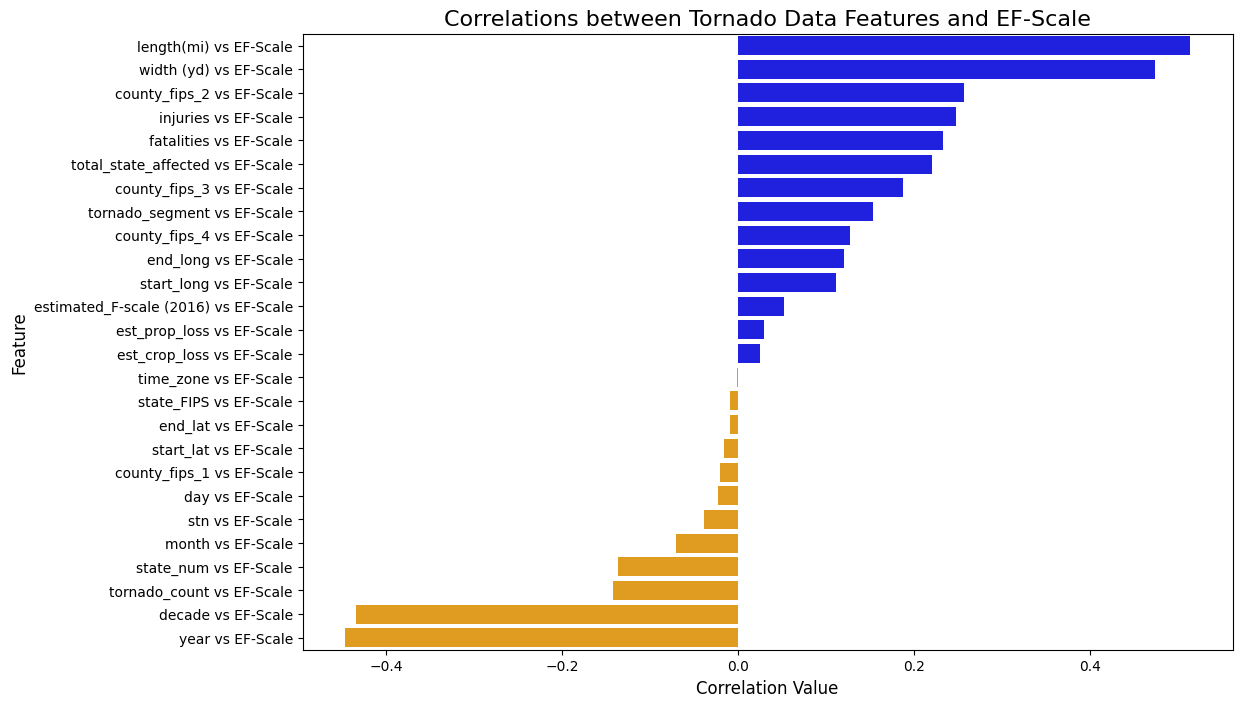

In [4]:
df = tornado_df
corr_items= ["EF-Scale"];

for corr_item in corr_items:

  print(corr_item)

  numeric_columns = get_numeric_columns(df, [corr_item])
  corr_values = []
  labels = []

  for column in numeric_columns:
      correlation_value = df[column].corr(df[corr_item])
      corr_values.append(round(correlation_value, 3))
      labels.append(f"{column} vs {corr_item}")

  correlation_df = pd.DataFrame({'Feature': labels, 'Correlation': corr_values})

  # Sort by descending order
  correlation_df = correlation_df.sort_values(by='Correlation', ascending=False)

  # Create a color list based on the sign of the correlation
  colors = ['blue' if value >= 0 else 'orange' for value in correlation_df['Correlation']]

  # Create a bar plot
  plt.figure(figsize=(12, 8))
  sns.barplot(x=correlation_df['Correlation'], y=correlation_df['Feature'], palette=colors)

  # Add titles and labels
  plt.title(f"Correlations between Tornado Data Features and {corr_item}", fontsize=16)
  plt.xlabel("Correlation Value", fontsize=12)
  plt.ylabel("Feature", fontsize=12)

  # Show the plot
  plt.show()

#Modeling

In [5]:
# Linear Regression Model:
#-----------------------------------------
from sklearn.linear_model import LinearRegression

def train_linear_regression(X, y, test_size=0.3, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Train the Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    return model, X_test, y_test
#-----------------------------------------

# Logistic Regression Model (for classification)
#-----------------------------------------
from sklearn.linear_model import LogisticRegression
def train_logistic_regression(X, y, test_size=0.3, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Train the Logistic Regression model
    model = LogisticRegression(max_iter=10000, random_state=random_state)
    model.fit(X_train, y_train)

    return model, X_test, y_test
#-----------------------------------------

# Random Forest Regressor Model:
#-----------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

def train_random_forest(X, y, test_size=0.3, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Train the Random Forest Regressor
    model = RandomForestRegressor(n_estimators=100, random_state=random_state)
    model.fit(X_train, y_train)

    return model, X_test, y_test
#-----------------------------------------

# Decision Tree Classifier With Hyperparameters:
#-----------------------------------------
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

def train_dtc_w_hyperparameters(
      X, y, #Features
      max_depth_range=range(2, 11), min_samples_split_range=[2, 5, 10, 25, 50], #Hyperparameters
      test_size=0.3, random_state=42 #Test Split
    ):

    results = []
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    for depth in max_depth_range:
        for min_split in min_samples_split_range:
            # Create and fit decision tree with hyperparameters
            dtc = DecisionTreeClassifier(max_depth=depth, min_samples_split=min_split)
            dtc.fit(X_train, y_train)

            # Predict on test set
            y_pred = dtc.predict(X_test)
            y_pred_proba = dtc.predict_proba(X_test)[:, 1]

            # Calculate metrics (rounded)
            accuracy = round(accuracy_score(y_test, y_pred), 3)
            auroc = round(roc_auc_score(y_test, y_pred_proba), 3)

            # Save results
            results.append({
                'max_depth': depth,
                'min_samples_split': min_split,
                'accuracy': accuracy,
                'auroc': auroc
            })

    results_df = pd.DataFrame(results)
    return results_df
#-----------------------------------------

# Gradient Boosting Classifier With Hyperparameters:
#-----------------------------------------
from sklearn.ensemble import GradientBoostingClassifier

def train_gradient_boosting_w_hyperparameters(
      X, y, #Features
      max_depth=5, n_estimators=100, min_samples_split=25, min_samples_leaf=25, #Hyperparameters
      test_size=0.3, random_state=42 #Test Split
    ):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    xgb = GradientBoostingClassifier(
        learning_rate=0.01,
        max_depth=max_depth,
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )

    xgb.fit(X_train, y_train)
    return xgb, X_test, y_test

#-----------------------------------------

length(mi)
Mean Absolute Error: 1.5011
R-squared: 0.8886
Root Mean Squared Error: 13.4011
Mean Absolute Percentage Error: 1798681026.37%


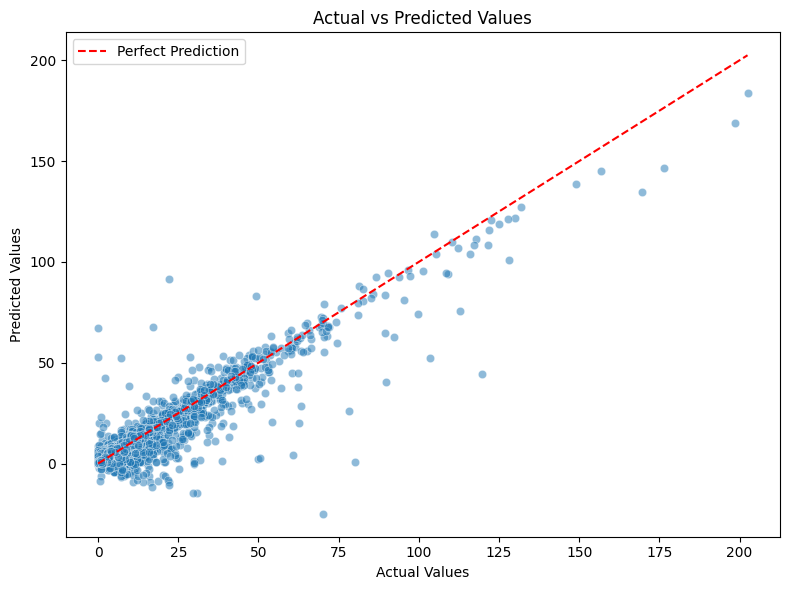

<ipython-input-6-51ecf93c6507>:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=importance_df, palette=colors)


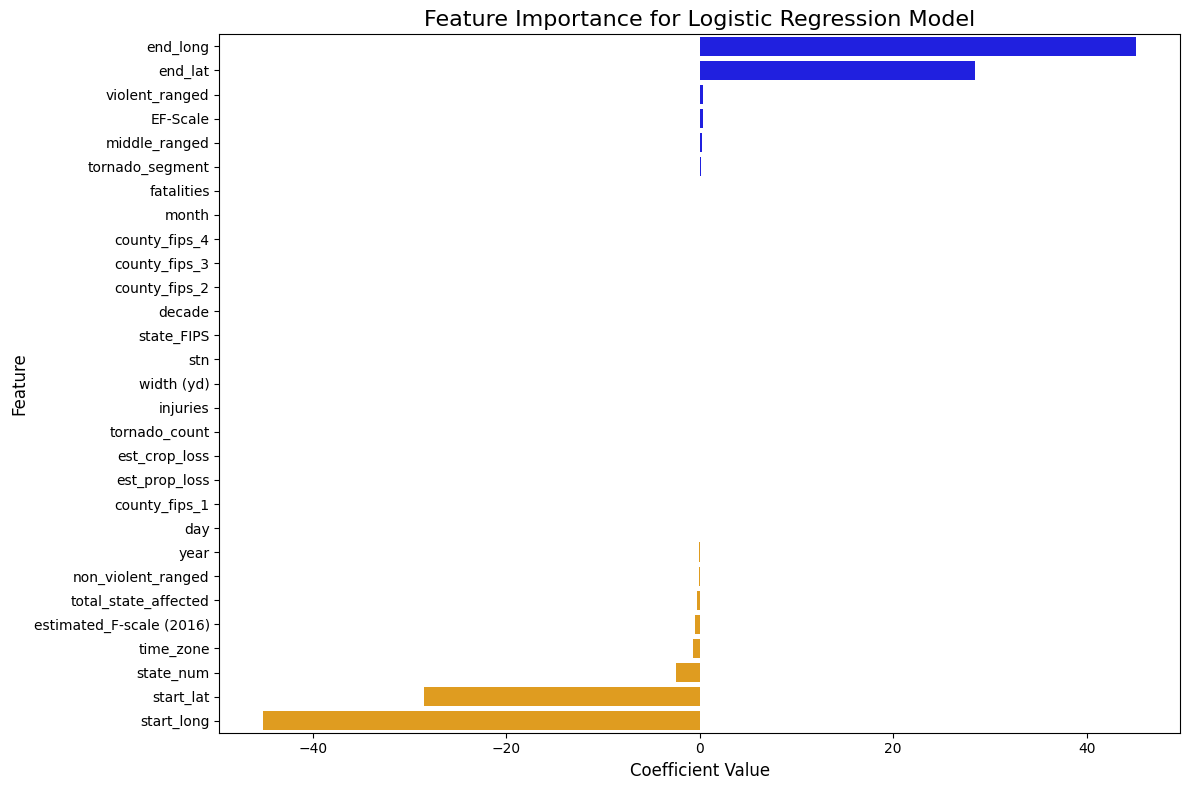

In [6]:
# LINEAR REGRESSION

df = tornado_df
df_extra = tornado_df_extra

# Merge dataframes
df_extra.index = df.index
df = pd.merge(df, df_extra, left_index=True, right_index=True, how='left')

pred_items = ["length(mi)"]

for pred_item in pred_items:

  print(pred_item)

  X = df[get_numeric_columns(df, [pred_item])]
  y = df[pred_item]

  # Train the model
  model, X_test, y_test = train_linear_regression(X, y)

  # Make predictions
  y_pred = model.predict(X_test)

  # Evaluate the model
  evaluate_model(model, X_test, y_test, y_pred, 'regression')

  # Visualize the predictions
  visualize_predictions(y_test, y_pred, 'regression')

  # Get feature names
  feature_names = X.columns.tolist()

  # Extract coefficients
  coef = model.coef_
  importance_df = pd.DataFrame({
      'Feature': feature_names,
      'Coefficient': coef
  })

  # Sort by absolute coefficient value (magnitude)
  importance_df = importance_df.sort_values(by='Coefficient', ascending=False)

  # Colors: blue for positive, orange for negative
  colors = ['blue' if value >= 0 else 'orange' for value in importance_df['Coefficient']]

  # Create bar plot
  plt.figure(figsize=(12, 8))
  sns.barplot(x='Coefficient', y='Feature', data=importance_df, palette=colors)
  plt.title(f"Feature Importance for Logistic Regression Model", fontsize=16)
  plt.xlabel("Coefficient Value", fontsize=12)
  plt.ylabel("Feature", fontsize=12)
  plt.tight_layout()
  plt.show()

middle_ranged


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7936

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.85      0.79      5821
           1       0.85      0.75      0.79      6697

    accuracy                           0.79     12518
   macro avg       0.80      0.80      0.79     12518
weighted avg       0.80      0.79      0.79     12518



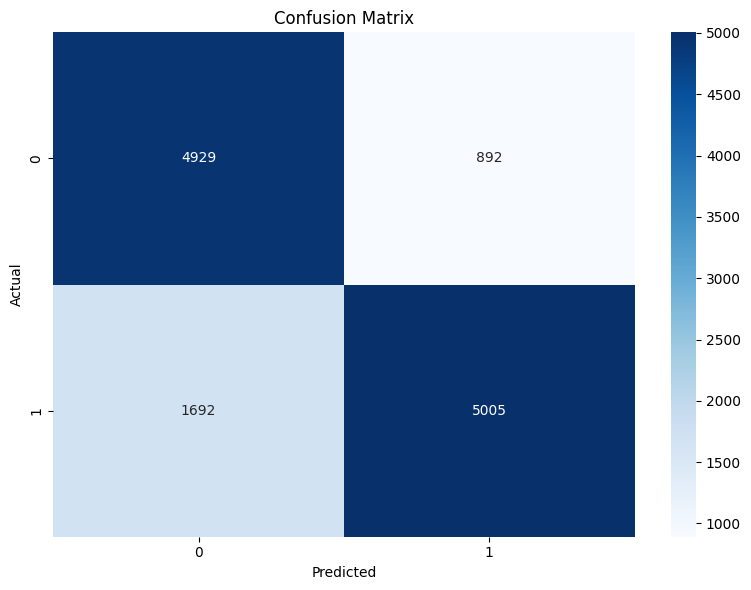

<ipython-input-7-fc8de1bbbbe9>:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=importance_df, palette=colors)


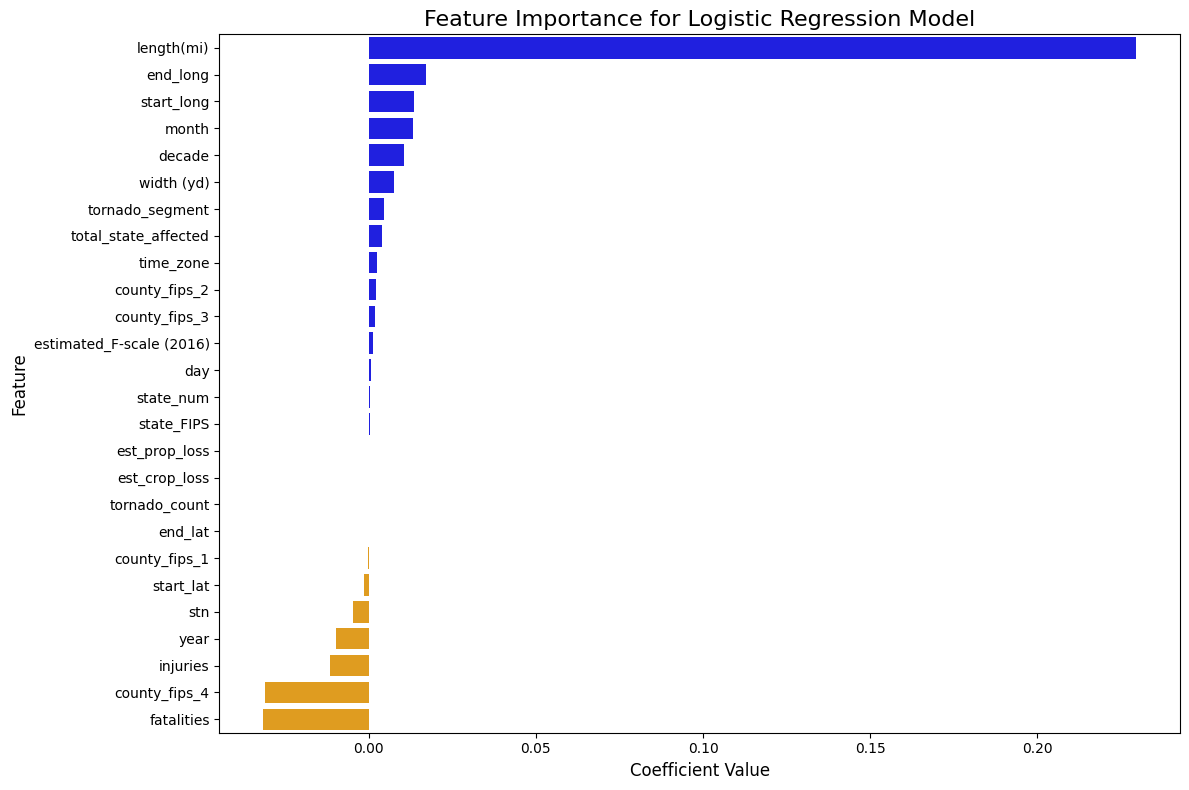

In [7]:
# LOGISTIC REGRESSION

df = tornado_df
df_extra = tornado_df_extra

# Merge dataframes
df_extra.index = df.index
df = pd.merge(df, df_extra, left_index=True, right_index=True, how='left')

pred_items = [
    "middle_ranged"
]
exclude_items = [
    ["valid_ranged", "middle_ranged", "violent_ranged", "non_violent_ranged", "EF-Scale"]
];

for i in range(len(pred_items)):

  print(pred_items[i])

  X = df[get_numeric_columns(df, exclude_items[i])]
  y = df[pred_items[i]]

  # Train the model
  model, X_test, y_test = train_logistic_regression(X, y)

  # Make predictions
  y_pred = model.predict(X_test)

  # Evaluate the model
  evaluate_model(model, X_test, y_test, y_pred, 'classification')

  # Visualize the predictions
  visualize_predictions(y_test, y_pred, 'classification')

  # Get feature names
  feature_names = X.columns.tolist()

  # Extract coefficients
  coef = model.coef_[0]  # For binary classification
  importance_df = pd.DataFrame({
      'Feature': feature_names,
      'Coefficient': coef
  })

  # Sort by absolute coefficient value (magnitude)
  importance_df = importance_df.sort_values(by='Coefficient', ascending=False)

  # Colors: blue for positive, orange for negative
  colors = ['blue' if value >= 0 else 'orange' for value in importance_df['Coefficient']]

  # Create bar plot
  plt.figure(figsize=(12, 8))
  sns.barplot(x='Coefficient', y='Feature', data=importance_df, palette=colors)
  plt.title(f"Feature Importance for Logistic Regression Model", fontsize=16)
  plt.xlabel("Coefficient Value", fontsize=12)
  plt.ylabel("Feature", fontsize=12)
  plt.tight_layout()
  plt.show()

In [8]:
import pandas as pd
def train_dtc_w_hyperparameters(
      X, y, #Features
      max_depth_range=range(2, 11), min_samples_split_range=range(2, 101), #Hyperparameters
      test_size=0.3, random_state=42 #Test Split
    ):

    results = []
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    for depth in max_depth_range:
        for min_split in min_samples_split_range:
            # Create and fit decision tree with hyperparameters
            dtc = DecisionTreeClassifier(max_depth=depth, min_samples_split=min_split)
            dtc.fit(X_train, y_train)

            # Predict on test set
            y_pred = dtc.predict(X_test)
            y_pred_proba = dtc.predict_proba(X_test)[:, 1]

            # Calculate metrics (rounded)
            accuracy = round(accuracy_score(y_test, y_pred), 3)
            auroc = round(roc_auc_score(y_test, y_pred_proba), 3)

            # Save results
            results.append({
                'max_depth': depth,
                'min_samples_split': min_split,
                'accuracy': accuracy,
                'auroc': auroc
            })

    results_df = pd.DataFrame(results)
    return results_df

middle_ranged


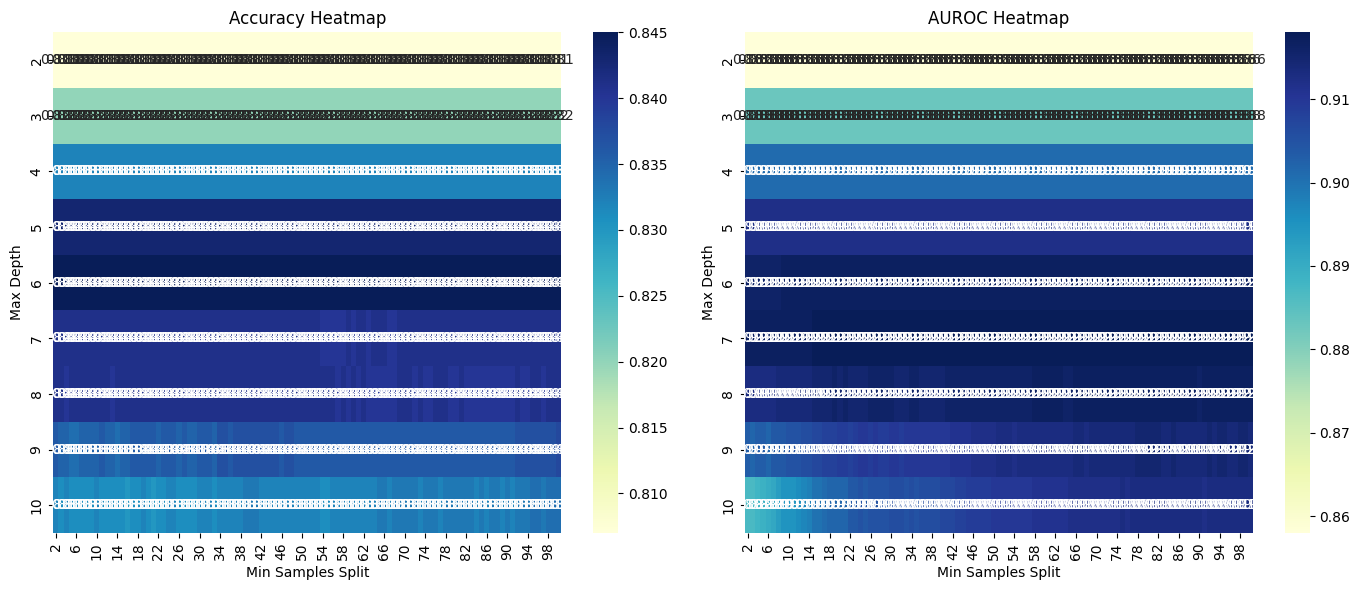

In [9]:
# DECISION TREE CLASSIFIER WITH HYPERPARAMETERS

df = tornado_df
df_extra = tornado_df_extra

# Merge dataframes
df_extra.index = df.index
df = pd.merge(df, df_extra, left_index=True, right_index=True, how='left')

pred_items = [
    "middle_ranged"
]
exclude_items = [
    ["middle_ranged", "violent_ranged", "non_violent_ranged", "EF-Scale"]
];

for i in range(len(pred_items)):

  print(pred_items[i])

  X = df[get_numeric_columns(df, exclude_items[i])]
  y = df[pred_items[i]]

  # Train the model
  results_df = train_dtc_w_hyperparameters(X, y)

  # Pivot for accuracy
  accuracy_pivot = results_df.pivot(
      index='max_depth',
      columns='min_samples_split',
      values='accuracy'
  )

  # Pivot for AUROC
  auroc_pivot = results_df.pivot(
      index='max_depth',
      columns='min_samples_split',
      values='auroc'
  )

  # Set up the figure with two subplots side by side
  plt.figure(figsize=(14, 6))

  # Plot heatmap for accuracy
  plt.subplot(1, 2, 1)
  sns.heatmap(accuracy_pivot, annot=True, fmt='.2f', cmap='YlGnBu')
  plt.title('Accuracy Heatmap')
  plt.xlabel('Min Samples Split')
  plt.ylabel('Max Depth')

  # Plot heatmap for AUROC
  plt.subplot(1, 2, 2)
  sns.heatmap(auroc_pivot, annot=True, fmt='.2f', cmap='YlGnBu')
  plt.title('AUROC Heatmap')
  plt.xlabel('Min Samples Split')
  plt.ylabel('Max Depth')

  # Display Heatmaps
  plt.tight_layout()
  plt.show()

middle_ranged
Accuracy: 0.8508

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      5821
           1       0.85      0.88      0.86      6697

    accuracy                           0.85     12518
   macro avg       0.85      0.85      0.85     12518
weighted avg       0.85      0.85      0.85     12518



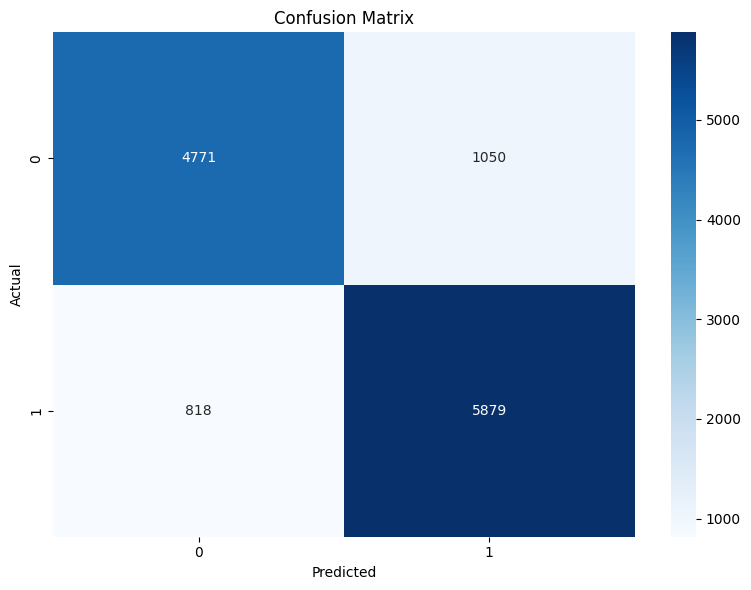

In [10]:
# GRADIENT BOOSTING CLASSIFIER WITH HYPERPARAMETERS

df = tornado_df
df_extra = tornado_df_extra

# Merge dataframes
df_extra.index = df.index
df = pd.merge(df, df_extra, left_index=True, right_index=True, how='left')

pred_items = [
    "middle_ranged"
]
exclude_items = [
    ["middle_ranged", "violent_ranged", "non_violent_ranged", "EF-Scale"]
];

for i in range(len(pred_items)):

  print(pred_items[i])

  X = df[get_numeric_columns(df, exclude_items[i])]
  y = df[pred_items[i]]

  # Train the model (Using Hyperparameters Based on Desision Tree Classifiers)
  model, X_test, y_test = train_gradient_boosting_w_hyperparameters(
      X, y,
      max_depth=8, min_samples_split=25
    )

  # Make predictions
  y_pred = model.predict(X_test)

  # Evaluate the model
  evaluate_model(model, X_test, y_test, y_pred, 'classification')

  # Visualize the predictions
  visualize_predictions(y_test, y_pred, 'classification')

  # # Display feature importance
  # feature_names = X.columns.tolist()
  # plot_feature_importance(model, feature_names)

  #Contribution to Prediction GRAPH
  #Glass Box Models!

In [11]:
# prompt: create a random forest regressor and print the accuracy score

def train_random_forest(X, y, test_size=0.3, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Train the Random Forest Regressor
    model = RandomForestRegressor(n_estimators=100, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    print(f"Accuracy: {accuracy}")
    return model, X_test, y_test


              precision    recall  f1-score   support

           0       0.86      0.85      0.85      3860
           1       0.87      0.88      0.87      4485

    accuracy                           0.86      8345
   macro avg       0.86      0.86      0.86      8345
weighted avg       0.86      0.86      0.86      8345



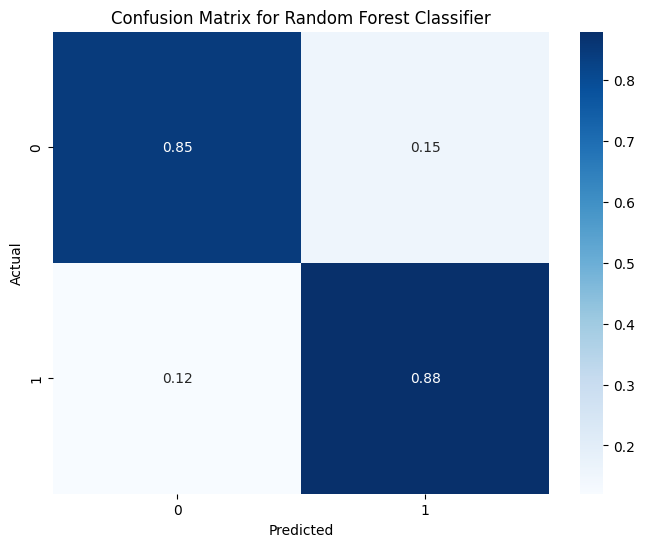

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split # Importing train_test_split

# Assuming X_train, y_train, X_valid, y_valid are defined from your previous code
# Example:
# X, y should be defined before this, representing your features and target variable
# For example, X could be df[['feature1', 'feature2', ...]] and y could be df['target_variable']
# Replace 'target_variable', 'feature1', 'feature2' with your actual column names

# Splitting the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42) # Defining X_train, X_valid, y_train, y_valid

rf = RandomForestClassifier(n_estimators=100, max_features=5, max_samples=0.5, random_state=42) # Added random_state for reproducibility
rf.fit(X_train, y_train)
y_pred = rf.predict(X_valid)
print(classification_report(y_valid, y_pred))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_valid, y_pred, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()

In [13]:
print(tornado_df['EF-Scale'].unique())

[1 3 2 4 0 5]


              precision    recall  f1-score   support

           0       0.86      0.85      0.85      3860
           1       0.87      0.88      0.87      4485

    accuracy                           0.86      8345
   macro avg       0.86      0.86      0.86      8345
weighted avg       0.86      0.86      0.86      8345



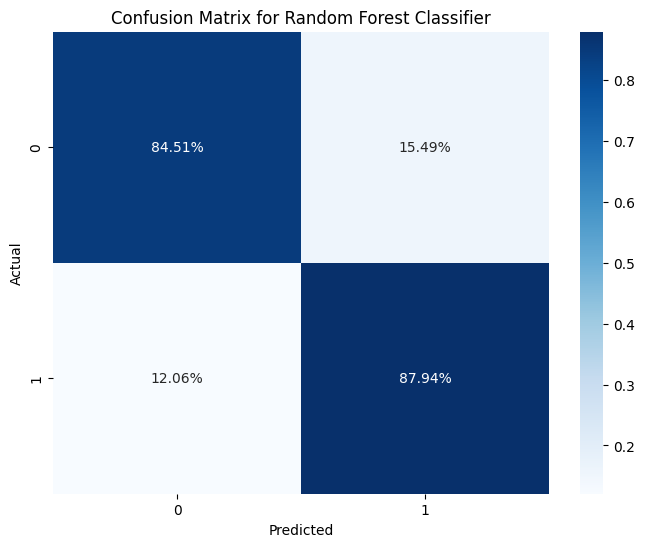

[1 3 2 4 0 5]


In [14]:
import matplotlib.pyplot as plt
# Assuming X_train, y_train, X_valid, y_valid are defined from your previous code
# Example:
# X, y should be defined before this, representing your features and target variable
# For example, X could be df[['feature1', 'feature2', ...]] and y could be df['target_variable']
# Replace 'target_variable', 'feature1', 'feature2' with your actual column names

# Splitting the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42) # Defining X_train, X_valid, y_train, y_valid

rf = RandomForestClassifier(n_estimators=100, max_features=5, max_samples=0.5, random_state=42) # Added random_state for reproducibility
rf.fit(X_train, y_train)
y_pred = rf.predict(X_valid)
print(classification_report(y_valid, y_pred))


# Confusion Matrix
cm = confusion_matrix(y_valid, y_pred, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues")  # Changed fmt to ".2%" for percentage display
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()

print(tornado_df['EF-Scale'].unique())


<ipython-input-15-0df2e1cb348e>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis") # Using a different color palette


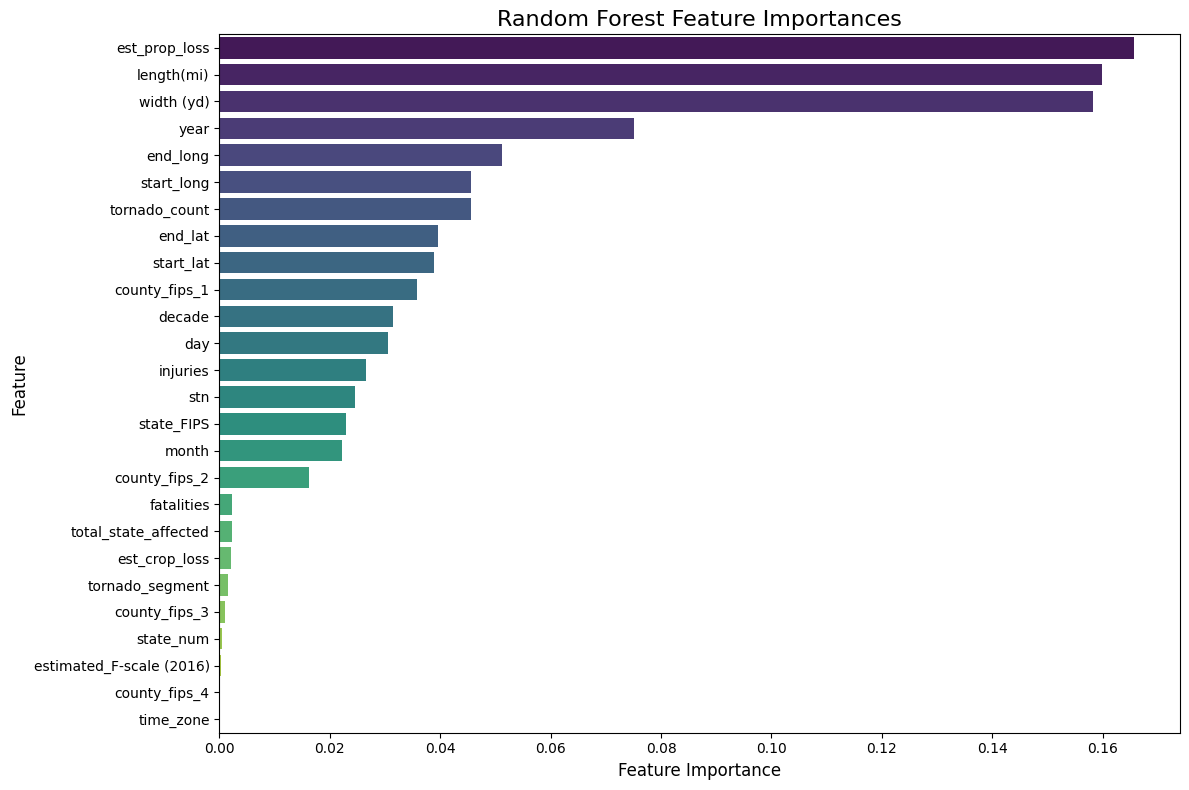

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract feature importances
importances = rf.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': X_train.columns,  # Use X_train columns
    'Importance': importances
})

# Sort by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Create the plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis") # Using a different color palette
plt.title("Random Forest Feature Importances", fontsize=16)
plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()


In [16]:
df.head()

,tornado_count,year,month,day,date,time,time_zone,state,state_FIPS,stn,EF-Scale,injuries,fatalities,est_prop_loss,est_crop_loss,start_lat,start_long,end_lat,end_long,length(mi),width (yd),total_state_affected,state_num,tornado_segment,county_fips_1,county_fips_2,county_fips_3,county_fips_4,estimated_F-scale (2016),decade,middle_ranged,violent_ranged,non_violent_ranged
0,192,1950,10,1,1950-10-01,21:00:00,3,OK,40,23,1,0,0,4.0,0.0,36.73,-102.52,36.88,-102.30,15.8,10,1,1,1,25,0,0,0,0,1950,1,0,1
1,194,1950,11,4,1950-11-04,17:00:00,3,PA,42,5,3,1,0,5.0,0.0,40.20,-76.12,40.40,-75.93,15.9,100,1,1,1,71,11,0,0,0,1950,1,1,0
2,198,1950,12,2,1950-12-02,15:00:00,3,IL,17,7,2,3,1,4.0,0.0,38.97,-90.05,39.07,-89.72,18.8,50,1,1,1,119,117,0,0,0,1950,1,0,0
3,199,1950,12,2,1950-12-02,16:00:00,3,IL,17,8,3,25,2,6.0,0.0,38.75,-89.67,38.90,-89.38,18.0,200,1,1,1,119,5,0,0,0,1950,1,1,0
4,200,1950,12,2,1950-12-02,16:25:00,3,AR,5,12,3,0,0,1.0,0.0,36.12,-91.83,36.18,-91.72,7.8,10,1,1,1,65,0,0,0,0,1950,1,1,0


In [17]:
# Assuming 'tornado_df' is your DataFrame
violent_ranged_sum = tornado_df_extra['violent_ranged'].sum()
medium_ranged_sum = tornado_df_extra['middle_ranged'].sum()

non_violent_ranged_sum = tornado_df_extra['non_violent_ranged'].sum()

print(f"Sum of violent_ranged: {violent_ranged_sum}")
print(f"Sum of med_ranged: {medium_ranged_sum}")
print
print(f"Sum of non_violent_ranged: {non_violent_ranged_sum}")


Sum of violent_ranged: 3013
Sum of med_ranged: 22351
Sum of non_violent_ranged: 13097


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


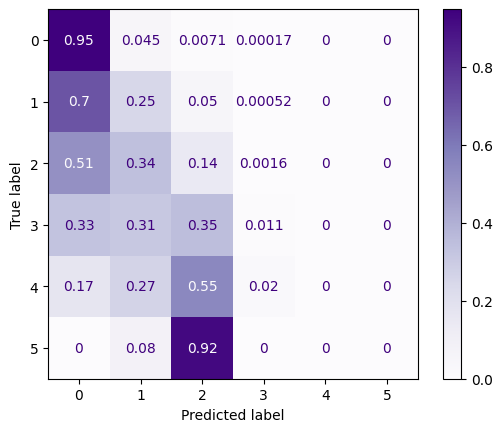

              precision    recall  f1-score   support

           0       0.58      0.95      0.72      5796
           1       0.45      0.25      0.32      3855
           2       0.30      0.14      0.19      1890
           3       0.44      0.01      0.02       749
           4       0.00      0.00      0.00       203
           5       0.00      0.00      0.00        25

    accuracy                           0.54     12518
   macro avg       0.30      0.23      0.21     12518
weighted avg       0.48      0.54      0.46     12518



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
from sklearn.model_selection import train_test_split

# Define your features (X) and target variable (y)
X = df.drop('EF-Scale', axis=1)  # Remove 'EF-Scale' from features
X = X.select_dtypes(include=np.number) # Only include numerical columns
y = tornado_df['EF-Scale']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train multinomial logistic regression
logr = LogisticRegression(max_iter=10**5, multi_class='multinomial', solver='lbfgs')
logr.fit(X_train, y_train)

# Make predictions
preds = logr.predict(X_test)

# Display confusion matrix
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=preds, normalize='true', cmap='Purples')
plt.show()

# You can also calculate other metrics like accuracy, precision, recall, F1-score using:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))


In [19]:
def categorize_ef_scale(ef_scale):
  if ef_scale in [1]:
    return "Low"
  elif ef_scale in [2, 3]:
    return "Medium"
  elif ef_scale in [4]:
    return "High"
  else:
    return "Unknown"  # Handle cases where EF-Scale is not in the expected range

# Apply the function to create the new column
df['EF-Scale_Category'] = df['EF-Scale'].apply(categorize_ef_scale)


In [20]:
df.head()

,tornado_count,year,month,day,date,time,time_zone,state,state_FIPS,stn,EF-Scale,injuries,fatalities,est_prop_loss,est_crop_loss,start_lat,start_long,end_lat,end_long,length(mi),width (yd),total_state_affected,state_num,tornado_segment,county_fips_1,county_fips_2,county_fips_3,county_fips_4,estimated_F-scale (2016),decade,middle_ranged,violent_ranged,non_violent_ranged,EF-Scale_Category
0,192,1950,10,1,1950-10-01,21:00:00,3,OK,40,23,1,0,0,4.0,0.0,36.73,-102.52,36.88,-102.30,15.8,10,1,1,1,25,0,0,0,0,1950,1,0,1,Low
1,194,1950,11,4,1950-11-04,17:00:00,3,PA,42,5,3,1,0,5.0,0.0,40.20,-76.12,40.40,-75.93,15.9,100,1,1,1,71,11,0,0,0,1950,1,1,0,Medium
2,198,1950,12,2,1950-12-02,15:00:00,3,IL,17,7,2,3,1,4.0,0.0,38.97,-90.05,39.07,-89.72,18.8,50,1,1,1,119,117,0,0,0,1950,1,0,0,Medium
3,199,1950,12,2,1950-12-02,16:00:00,3,IL,17,8,3,25,2,6.0,0.0,38.75,-89.67,38.90,-89.38,18.0,200,1,1,1,119,5,0,0,0,1950,1,1,0,Medium
4,200,1950,12,2,1950-12-02,16:25:00,3,AR,5,12,3,0,0,1.0,0.0,36.12,-91.83,36.18,-91.72,7.8,10,1,1,1,65,0,0,0,0,1950,1,1,0,Medium


# Model Predictions Across Different Intensities

In [21]:
import pandas as pd
# Calculate the number of rows needed for each category
n_rows_per_category = df['EF-Scale_Category'].value_counts().min()

# Create a new DataFrame with balanced categories
balance_df = pd.DataFrame()
for category in df['EF-Scale_Category'].unique():
    if category != 'Unknown':
        temp_df = df[df['EF-Scale_Category'] == category].sample(n_rows_per_category, random_state=42)
        balance_df = pd.concat([balance_df, temp_df])

# Print the value counts of the new DataFrame
print(balance_df['EF-Scale_Category'].value_counts())


EF-Scale_Category
Low       674
Medium    674
High      674
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


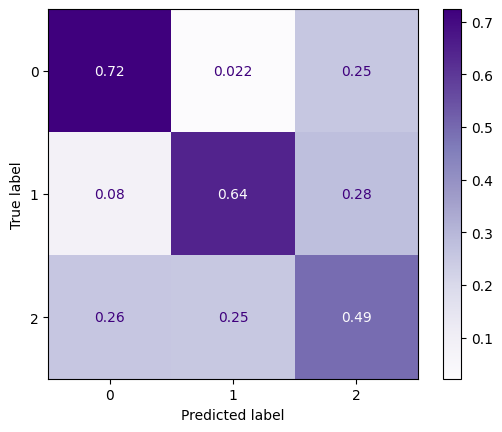

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

# Define your features (X) and target variable (y)
X = balance_df[['width (yd)', 'length(mi)', 'fatalities', 'est_prop_loss', 'est_crop_loss', 'injuries', 'tornado_count', 'state_FIPS',]]  # Replace with relevant features
y = balance_df['EF-Scale_Category']  # This should have values like 'Low', 'Medium', 'High'

# Convert categorical target to numerical labels (if needed)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Converts 'Low', 'Medium', 'High' into 0, 1, 2

# Train multinomial logistic regression
logr = LogisticRegression(max_iter=10**5, multi_class='multinomial', solver='lbfgs')
logr.fit(X, y_encoded)

# Make predictions
preds = logr.predict(X)

# Add predictions back to the dataset (optional)
balance_df['logr_preds'] = le.inverse_transform(preds)  # Convert numbers back to labels

# Display confusion matrix
ConfusionMatrixDisplay.from_predictions(y_true=y_encoded, y_pred=preds, normalize='true', cmap='Purples')


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


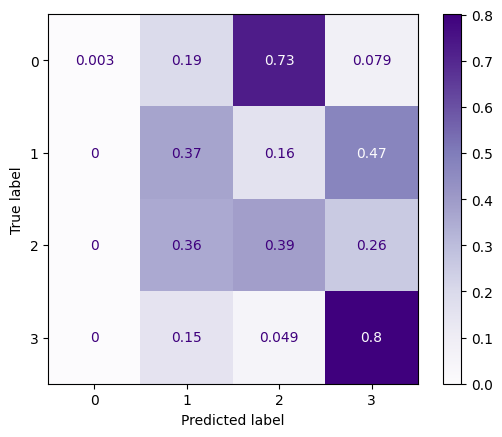

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

# Define your features (X) and target variable (y)
X = df[['county_fips_4', 'county_fips_3', 'county_fips_2',
                 'county_fips_1', 'width (yd)', 'length(mi)', 'fatalities', 'est_prop_loss', 'est_crop_loss', 'injuries', 'tornado_count', 'state_FIPS']]  # Replace with relevant features
y = df['EF-Scale_Category']  # This should have values like 'Low', 'Medium', 'High'

# Convert categorical target to numerical labels (if needed)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Converts 'Low', 'Medium', 'High' into 0, 1, 2

# Train multinomial logistic regression
logr = LogisticRegression(max_iter=10**5, multi_class='multinomial', solver='lbfgs')
logr.fit(X, y_encoded)

# Make predictions
preds = logr.predict(X)

# Add predictions back to the dataset (optional)
tornado_df['logr_preds'] = le.inverse_transform(preds)  # Convert numbers back to labels

# Display confusion matrix
ConfusionMatrixDisplay.from_predictions(y_true=y_encoded, y_pred=preds, normalize='true', cmap='Purples')


In [24]:
logr = LogisticRegression(max_iter=5000)

# Define features and target variable
X = df[[         'county_fips_4', 'county_fips_3', 'county_fips_2',
                 'county_fips_1', 'width (yd)', 'length(mi)', 'fatalities', 'est_prop_loss', 'est_crop_loss', 'injuries', 'tornado_count', 'state_FIPS']]
y = df['EF-Scale']

# Correctly apply the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train on the training set
logr.fit(X_train, y_train)

# Make predictions on the test set
preds = logr.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, preds))
print("\nClassification Report:\n", classification_report(y_test, preds))


Accuracy: 0.5002396548969484

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.71      0.68      5796
           1       0.39      0.39      0.39      3855
           2       0.28      0.33      0.30      1890
           3       1.00      0.01      0.01       749
           4       0.00      0.00      0.00       203
           5       0.00      0.00      0.00        25

    accuracy                           0.50     12518
   macro avg       0.39      0.24      0.23     12518
weighted avg       0.52      0.50      0.48     12518



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

In [25]:
# prompt: Balance the dataset, save it back as balanced_df

import pandas as pd
from sklearn.utils import resample

# Assuming your DataFrame is named 'df' and the target variable column is 'target_column'
# Replace 'target_column' with the actual name of your target variable column

# Separate majority and minority classes
df_majority = df[df['EF-Scale'] == 0]
df_minority = df[df['EF-Scale'] == 1]

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,  # sample with replacement
                                 n_samples=len(df_majority),  # to match majority class
                                 random_state=42)  # reproducible results

# Combine majority class with upsampled minority class
balanced_df = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
print(df['EF-Scale'].value_counts())


EF-Scale
0    19292
1    13097
2     6241
3     2339
4      674
5       81
Name: count, dtype: int64


In [26]:
df.head()

,tornado_count,year,month,day,date,time,time_zone,state,state_FIPS,stn,EF-Scale,injuries,fatalities,est_prop_loss,est_crop_loss,start_lat,start_long,end_lat,end_long,length(mi),width (yd),total_state_affected,state_num,tornado_segment,county_fips_1,county_fips_2,county_fips_3,county_fips_4,estimated_F-scale (2016),decade,middle_ranged,violent_ranged,non_violent_ranged,EF-Scale_Category
0,192,1950,10,1,1950-10-01,21:00:00,3,OK,40,23,1,0,0,4.0,0.0,36.73,-102.52,36.88,-102.30,15.8,10,1,1,1,25,0,0,0,0,1950,1,0,1,Low
1,194,1950,11,4,1950-11-04,17:00:00,3,PA,42,5,3,1,0,5.0,0.0,40.20,-76.12,40.40,-75.93,15.9,100,1,1,1,71,11,0,0,0,1950,1,1,0,Medium
2,198,1950,12,2,1950-12-02,15:00:00,3,IL,17,7,2,3,1,4.0,0.0,38.97,-90.05,39.07,-89.72,18.8,50,1,1,1,119,117,0,0,0,1950,1,0,0,Medium
3,199,1950,12,2,1950-12-02,16:00:00,3,IL,17,8,3,25,2,6.0,0.0,38.75,-89.67,38.90,-89.38,18.0,200,1,1,1,119,5,0,0,0,1950,1,1,0,Medium
4,200,1950,12,2,1950-12-02,16:25:00,3,AR,5,12,3,0,0,1.0,0.0,36.12,-91.83,36.18,-91.72,7.8,10,1,1,1,65,0,0,0,0,1950,1,1,0,Medium


In [27]:
# prompt: count the amount of each values in EF-Scale

import pandas as pd

# Assuming your DataFrame is named 'tornado_df'
# Replace 'tornado_df' with the actual name of your DataFrame if different
value_counts = tornado_df['EF-Scale'].value_counts()
value_counts


,count
EF-Scale,
0,19292
1,13097
2,6241
3,2339
4,674
5,81


In [28]:
from sklearn.linear_model import LogisticRegression

logr = LogisticRegression(max_iter=10**5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Picking a few random columns, experiment with these (or add all of them)
# ** Replace with train-test-validation split **
X = balanced_df[['middle_ranged', 'violent_ranged', 'non_violent_ranged', 'county_fips_4', 'county_fips_3', 'county_fips_2', 'county_fips_1', 'width (yd)', 'length(mi)', 'fatalities']]
y = balanced_df['EF-Scale']

logr.fit(X, y)

preds = logr.predict(X)

df['logr_preds'] = preds

print("Accuracy:", accuracy_score(y, preds))
print("\nClassification Report:\n", classification_report(y, preds))


ValueError: Length of values (38584) does not match length of index (41724)

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
logr = LogisticRegression(max_iter=10**5)
logr.fit(X_train, y_train)

# Predict on the test set
preds = logr.predict(X_test)
balanced_df.loc[X_test.index, 'logr_preds'] = preds

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, preds))
print("\nClassification Report:\n", classification_report(y_test, preds))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, preds))


ValueError: shape mismatch: value array of shape (7717,) could not be broadcast to indexing result of shape (13332,)